In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import pyramid
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
dn = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv',parse_dates=['date'], index_col='date',usecols=[*range(1, 15)])
dm = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
dh = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
dg = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/regionalGDP_2010-2015.csv',parse_dates=['date'],index_col='date',usecols=[*range(1, 15)])
dr = pd.concat([dn, dm, dh, dg], axis=1)
df = dr.dropna()
df = df[['nights_PDL','avgtemp_PDL','gdp_PDL','daysoff']]
exog_df = df[['avgtemp_PDL','daysoff']]
exogenous= np.array(df[['avgtemp_PDL','daysoff']])
y = np.array(df[['nights_PDL','gdp_PDL']])
df_y = df[['nights_PDL','gdp_PDL']]

In [3]:
from statsmodels.tsa.stattools import adfuller

for column in df_y.columns:
    result = adfuller(df_y[column])
#     print(f'Stationarity test for variable {column}')
#     print('ADF Statistic: %f' % result[0])
#     print('p-value: %f' % result[1])
#     print('Critical Values:')

#     for key, value in result[4].items():
#         print('\t%s: %.3f' % (key, value))
    
    if result[1] < 0.05:
        print('STATIONARY')
        print(f'{column}')
        print('-------')
    else:
        print('NON-STATIONARY')
        print(f'{column}')
        print('-------')

NON-STATIONARY
nights_PDL
-------
NON-STATIONARY
gdp_PDL
-------


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

# ----- Additive Model below -----

add_data = seasonal_decompose(df_y, model='additive')  

add_trend = add_data.trend.dropna()
add_seasonal = add_data.seasonal.dropna()
add_residual = add_data.resid.dropna()

# stationarity_test(add_residual)

# ----- Multiplicative Model below -----

mult_data = seasonal_decompose(df_y, model='multiplicative')  

mult_trend = mult_data.trend.dropna()
mult_seasonal = mult_data.seasonal.dropna()
mult_residual = mult_data.resid.dropna()

# stationarity_test(mult_residual)

In [5]:
from statsmodels.tsa.stattools import acf

add_acfs = add_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

mult_acfs = mult_residual.apply(acf, axis=0).apply(np.square, axis=0).apply(np.sum)

additive = add_acfs < mult_acfs
add_cols = additive.index[additive].tolist()
mult_cols = additive.index[~additive].tolist()
print('Additive:', add_cols)
print('Multiplicative', mult_cols)

Additive: ['nights_PDL']
Multiplicative ['gdp_PDL']


Nights PDL is additive

In [6]:
add_exog = seasonal_decompose(exog_df, model='additive')
add_exog_resid = add_exog.resid.dropna()
add_exog_resid.head()
# print(np.size(add_exog_resid, axis=0))
# print(np.size(add_residual, axis=0))

,avgtemp_PDL,daysoff
date,,
2010-07-01,2.324306,0.863889
2010-08-01,0.315972,-1.311111
2010-09-01,-0.509028,-0.119444
2010-10-01,-1.875694,1.438889
2010-11-01,-1.400694,-0.061111


In [7]:
add_seasonal_2016 = add_seasonal[(add_seasonal.index>='2015-01-01')&(add_seasonal.index<'2016-01-01')]
add_seasonal_2016.head(1)

,nights_PDL,gdp_PDL
date,,
2015-01-01,-169.663271,1196.976573


In [8]:
from pyramid.arima import auto_arima
arima_trend = auto_arima(np.array(add_trend.nights_PDL), start_p=0, start_q=0, max_p=20, max_q=20, m=12,
                    start_P=0, max_P=20, seasonal=False, d=1, D=1, trace=True,
                    error_action='ignore', suppress_warnings=True, stepwise=False, random=True, random_state=42) 

arima_trend.summary()


Fit ARIMA: order=(6, 1, 3); AIC=189.030, BIC=211.883, Fit time=0.831 seconds
Fit ARIMA: order=(8, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0); AIC=242.666, BIC=246.821, Fit time=0.004 seconds
Fit ARIMA: order=(5, 1, 0); AIC=197.106, BIC=211.649, Fit time=0.137 seconds
Fit ARIMA: order=(0, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(9, 1, 0); AIC=194.071, BIC=216.924, Fit time=1.017 seconds
Fit ARIMA: order=(1, 1, 5); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1); AIC=204.095, BIC=212.405, Fit time=0.065 seconds
Fit ARIMA: order=(10, 1, 0); AIC=195.575, BIC=220.505, Fit time=1.296 seconds
Fit ARIMA: order=(3, 1, 0); AIC=199.633, BIC=210.020, Fit time=0.074 seconds
Total fit time: 3.461 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(6, 1, 3)   Log Likelihood                 -83.515
Method:                       css-mle   S.D. of innovations              0.916
Date:                Thu, 23 Aug 2018   AIC                            189.030
Time:                        11:35:51   BIC                            211.883
Sample:                             1   HQIC                           197.951
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8525      0.590      1.445      0.155      -0.304       2.009
ar.L1.D.y      0.6516      0.147      4.442      0.000       0.364       0.939
ar.L2.D.y     -0.3874      0.155     -2.496      0.016      -0.692      -0.083
ar.L3.D.y      0.1351      0.162      0.834      0.408      -0.182       0.453
ar.L4.D.y      0.0977      0.167      0.587      0.560      -0.229       0.424
ar.L5.D.y      0.2156      0.166      1.300      0.200      -0.109       0.540
ar.L6.D.y     -0.1601      0.134     -1.192      0.239      -0.423       0.103
ma.L1.D.y      0.1595      0.125      1.277      0.208      -0.085       0.404
ma.L2.D.y      0.1595      0.129      1.234      0.223      -0.094       0.413
ma.L3.D.y      1.0000      0.136      7.356      0.000       0.734       1.266
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1143           -0.9141j            1.4413           -0.3907
AR.2           -1.1143           +0.9141j            1.4413            0.3907
AR.3            0.2743           -1.1027j            1.1363           -0.2112
AR.4            0.2743           +1.1027j            1.1363            0.2112
AR.5            1.5132           -0.1972j            1.5260           -0.0206
AR.6            1.5132           +0.1972j            1.5260            0.0206
MA.1           -1.0000           -0.0000j            1.0000           -0.5000
MA.2            0.4202           -0.9074j            1.0000           -0.1810
MA.3            0.4202           +0.9074j            1.0000            0.1810
-----------------------------------------------------------------------------
"""

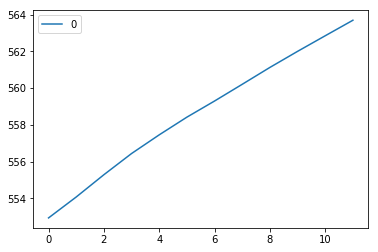

In [9]:
arima_trend.fit(add_trend.nights_PDL)
arima_trend_forecast_2016 = arima_trend.predict(n_periods=12)
arima_trend_forecast_2016
arima_trend_forecast_2016_df = pd.DataFrame(arima_trend_forecast_2016)
arima_trend_forecast_2016_df.plot()

In [24]:
from statsmodels.tsa.api import VAR, DynamicVAR

model = VAR(endog=add_residual, exog=add_exog_resid, dates=add_residual.index)

lagorder_results = model.select_order(24)
print(lagorder_results.summary())

# Need to test and see if 20 lags with NaN gives good results
results = model.fit(maxlags=18, ic='aic')
print(results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        16.19       16.45   1.071e+07       16.28
1        15.96       16.40   8.574e+06       16.11
2        15.97       16.59   8.752e+06       16.19
3        16.15       16.94   1.057e+07       16.43
4        16.28       17.25   1.223e+07       16.62
5        16.30       17.45   1.287e+07       16.70
6        16.23       17.55   1.250e+07       16.69
7        15.94       17.44   9.848e+06       16.46
8        15.90       17.58   1.024e+07       16.49
9        15.52       17.36   7.669e+06       16.16
10       15.44       17.46   8.123e+06       16.15
11       15.27       17.47   8.194e+06       16.04
12       14.12       16.50   3.308e+06       14.95
13       13.76       16.32   3.267e+06       14.66
14       13.75       16.47   5.347e+06       14.70
15       12.55       15.46   3.822e+06       13.57
16      -28.95      -25.87   2.

In [11]:
temp = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/avgtemp_2010-2017.csv',parse_dates=['date'],index_col='date')
daysoff = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/daysoff_2010-2017.csv',parse_dates=['date'],index_col='date',usecols=['date','daysoff'])
temp_PDL = temp[['avgtemp_PDL']]
temp_PDL_2016 = temp[(temp.index>='2016-01-01')&(temp.index<'2017-01-01')]
temp_PDL_2016 = temp_PDL_2016[['avgtemp_PDL']]

daysoff_2016 = daysoff[(daysoff.index>='2016-01-01')&(daysoff.index<'2017-01-01')]

exog_future_df = pd.concat([temp_PDL_2016, daysoff_2016], axis=1, sort=False)
exog_future_df

,avgtemp_PDL,daysoff
date,,
2016-01-01,9.0,11
2016-02-01,9.0,9
2016-03-01,10.0,10
2016-04-01,12.0,10
2016-05-01,16.0,11
2016-06-01,19.0,9
2016-07-01,21.0,12
2016-08-01,23.0,10
2016-09-01,21.0,9


In [12]:
lag_order = results.k_ar
print(lag_order)

# exog_future: Future values of exog variables. 
    # Length must be the same length as the number of steps you want to predict
    # In this case; 12 months into the future

add_resid_forecast_2016 = results.forecast(add_residual.values[-lag_order:], 12, 
                                           exog_future=exog_future_df)
add_resid_forecast_2016

18


array([[ 4.55068098e+01, -1.97032740e+02],
       [ 2.34484813e+01, -3.59003977e+00],
       [ 4.41045283e+01,  1.34210968e+01],
       [ 1.09924139e+01, -2.94412436e+01],
       [ 2.50658229e+01,  1.24309706e+01],
       [ 1.84830778e+01,  3.36091621e+02],
       [ 3.81499702e+01,  5.89913414e+02],
       [ 1.41139267e+01,  8.15086914e+02],
       [ 4.08105471e+01,  6.62734108e+02],
       [ 3.40426137e+01,  4.11634705e+02],
       [ 4.22009866e+01,  2.09888863e+02],
       [ 1.54285296e+01,  5.22024965e-01]])

In [13]:
add_resid_forecast_2016_df = pd.DataFrame(add_resid_forecast_2016)
add_resid_forecast_2016_df.head()

,0,1
0,45.506810,-197.032740
1,23.448481,-3.590040
2,44.104528,13.421097
3,10.992414,-29.441244
4,25.065823,12.430971


In [14]:
add_seasonal_2016_array = add_seasonal_2016.nights_PDL.values
add_seasonal_2016_df = pd.DataFrame(add_seasonal_2016_array)
add_seasonal_2016_df.head(2)

,0
0,-169.663271
1,-153.071438


In [15]:
forecast_2016 = add_seasonal_2016_df[0] + arima_trend_forecast_2016_df[0] + add_resid_forecast_2016_df[0]
forecast_2016

0     428.775881
1     424.448348
2     515.870398
3     557.405893
4     631.332760
5     734.314997
6     769.183750
7     825.205216
8     692.694320
9     574.653902
10    492.966020
11    409.248690
Name: 0, dtype: float64

In [16]:
nights_PDL_2016 = pd.read_csv('/Users/jinny/Documents/touristcast/datasets/nights_2010-2017.csv')
nights_PDL_2016 = nights_PDL_2016.drop('Unnamed: 0', axis=1)
nights_PDL_2016

nights_PDL_2016 = nights_PDL_2016[['date', 'nights_PDL']]
nights_PDL_2016['date'].apply(pd.to_datetime)
nights_PDL_2016 = nights_PDL_2016.set_index('date')

nights_PDL_2016 = nights_PDL_2016[(nights_PDL_2016.index>='2016-01-01')&(nights_PDL_2016.index<'2017-01-01')]
nights_PDL_2016 = np.array(nights_PDL_2016.nights_PDL)
nights_PDL_2016_df = pd.DataFrame(nights_PDL_2016)

In [17]:
results.aic

11.34794767191956

In [18]:
# Define seasonality as 12 (monthly data) in argument when ground truth data includes at least 24 months

def seasonal_MASE(truth, forecast, seasonality=1):    
    period = truth.shape[0] # T
    # print(period)
    forecast_errors = np.abs(truth - forecast)
    # print(forecast_errors)
    mean_absolute_forecast_error = np.sum(forecast_errors) / period
    # print(mean_absolute_forecast_error)

    naive_period = truth.shape[0] - seasonality # T - m
    # print(naive_period)
    # print(truth[seasonality:])
    # print(truth[:period - seasonality])
    naive_errors = np.abs(truth[seasonality:] - truth[:period - seasonality])
    mean_absolute_naive_error = np.sum(naive_errors) / naive_period
    
    return mean_absolute_forecast_error / mean_absolute_naive_error

In [19]:
MASE_2016 = seasonal_MASE(nights_PDL_2016, forecast_2016)
print("Jinny's MASE measure:", MASE_2016)

Jinny's MASE measure: 0.26987168890403457


In [20]:
from math import sqrt
def MASE(testing_series, prediction_series):
    n = testing_series.shape[0]
    scalingFactor = prediction_series.mean()
    forecast_errors = testing_series - prediction_series
    scaledErrors = forecast_errors/(np.sum(np.abs(testing_series - scalingFactor)) / n)
    return np.abs(scaledErrors).mean()

mase_alt = MASE(nights_PDL_2016, forecast_2016)
print("Aysun's MASE measure:", mase_alt)

Aysun's MASE measure: 0.17881872489203857


In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse_2016 = np.sqrt(mean_squared_error(nights_PDL_2016, forecast_2016))
mae_2016 = mean_absolute_error(nights_PDL_2016, forecast_2016)
print('RMSE:', rmse_2016)
print('MAE:', mae_2016)

RMSE: 30.68439956399531
MAE: 23.772261061859396


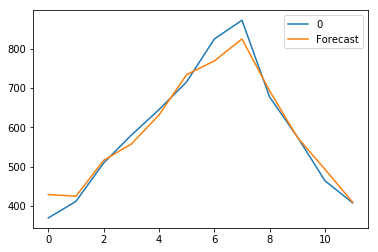

In [22]:
nights_PDL_2016_df.plot(label='Real')
forecast_2016.plot(label='Forecast')
plt.legend()